# UMI shoeboxer & results testing

#### Imports

In [1]:
from umi.ubem import UBEM
from utils.constants import *

import os
from pathlib import Path

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import plotly

from ladybug.epw import EPW
from archetypal import UmiTemplateLibrary

c:\Users\zoelh\AppData\Local\anaconda3\envs\ml-for-bem\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package energy-pandas is out of date. Your version is 0.3.3, the latest is 0.3.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


[Taichi] version 1.6.0, llvm 15.0.1, commit f1c6fbbd, win, python 3.8.16
[Taichi] Starting on arch=cuda


## 1. Open and build umi shoeboxes from .umi

In [17]:
umi_test = UBEM.open_umi(
    filename="D:/Users/zoelh/GitRepos/ml-for-building-energy-modeling/umi_data/Florianopolis/seed_florianopolis.umi",
    height_col="Height",
    id_col="id",
    wwr_col="WwrS",
    shoebox_gen_type="unshaded",
)

INFO:UMI:reading input file...
DEBUG:UMI:TEMPORARY LOCATION C:\Users\zoelh\AppData\Local\Temp\tmpja3cy2o0
INFO:UMI:Successfully loaded EPW file Data for [Florianópolis]
DEBUG:UMI:['sdl-common/district_energy_scenarios.json', 'sdl-common/planningSettings.json', 'sdl-common/project.json', 'sdl-common/shoebox-weights.json', 'sdl-common/site-analysis-settings.json', 'sdl-common/ThermalPlantSettings.json', 'sdl-common/ubemio-archetype-id-cache.json', 'sdl-common/ud-results.xml', 'sdl-common/project-settings.json', 'sdl-common/project-header.json', 'Florianopolis_Baseline.3dm', 'BRA_SC-Florianopolis.838970_INMET.epw', 'CZ4A.json', 'umi.sqlite3']
INFO:UMI:Opening archetpal templates at CZ4A.json
DEBUG:UMI:Index(['id', 'FloorCount', 'GrossFloorArea', 'Height', 'Name', 'Occupancy',
       'TemplateName', 'UseType', 'WwrE', 'WwrN', 'WwrS', 'WwrW', 'geometry'],
      dtype='object')
INFO:UMI:Read 9.8KB from D:/Users/zoelh/GitRepos/ml-for-building-energy-modeling/umi_data/Florianopolis/seed_floria

## or 2. Load from gdf, epw, and template_lib directly

In [ ]:
gdf = gpd.read_file(Path("data") / "gis" / "Florianopolis_Baseline.zip")

# dict to store key fields for known gis files
id_cols = {
    "height_col": "HEIGHT",
    "id_col": "OBJECTID",
    "template_name_col": "template_name",
    "wwr_col": "wwr",
}

epw_fp = (
    Path("data")
    / "epws"
    / "global_epws_indexed"
    / "cityidx_0033_BRA_SP-São Paulo-Congonhas AP.837800_TRY Brazil.epw"
)

epw = EPW(epw_fp)
template_lib = UmiTemplateLibrary.open(
    Path("data") / "template_libs" / "cz_libs" / "residential" / "CZ4A.json"
)

# Insert dummy template names
gdf[id_cols["template_name_col"]] = np.random.choice(
    [t.Name for t in template_lib.BuildingTemplates], size=gdf.shape[0]
)
# insert dummy wwrs
gdf[id_cols["wwr_col"]] = 0.4

umi_test = UBEM(
    gdf=gdf,
    **id_cols,
    epw=epw,
    template_lib=template_lib,
    shoebox_width=3,
    floor_to_floor_height=4,
    perim_offset=PERIM_OFFSET,
)

print("SCHEDULES ARRAY: ", umi_test.schedules_array.shape)
print("TEMPLATE DF: ", umi_test.template_features_df.shape)
print("EPW ARRAY: ", umi_test.epw_array.shape)

# TODO:
# Shading vector / RayTracing
# mapping
# using numerics for orientation instead of words?
# infiltration/ventilation etc


Looking at the features we have pulled from the templates, check the distributions of each.

In [4]:
umi_test.template_features_df[
    [
        "PeopleDensity",
        "LightingPowerDensity",
        "EquipmentPowerDensity",
        "Infiltration",
        "VentilationPerArea",
        "VentilationPerPerson",
        "VentilationMode",
        "HeatingSetpoint",
        "CoolingSetpoint",
        "RecoverySettings",
        "EconomizerSettings",
        "FacadeRValue",
        "FacadeMass",
        "RoofRValue",
        "RoofMass",
        "SlabRValue",
        "WindowShgc",
        "WindowUValue",
    ]
].apply(pd.to_numeric, errors="ignore").describe()

,PeopleDensity,LightingPowerDensity,EquipmentPowerDensity,Infiltration,VentilationPerArea,VentilationPerPerson,VentilationMode,HeatingSetpoint,CoolingSetpoint,RecoverySettings,EconomizerSettings,FacadeRValue,FacadeMass,RoofRValue,RoofMass,SlabRValue,WindowShgc,WindowUValue
count,6.00,6.000000,6.000000,6.000000,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.000000,6.0,6.000000,6.0,6.000000,6.0,6.000000
mean,0.02,3.361667,5.395000,1.180000,0.0,0.0,1.0,20.0,26.0,0.0,0.0,1.368652,1.0,4.907412,1.0,4.790449,1.0,79.554732
std,0.00,0.077050,0.528687,0.186226,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.082008,0.0,0.544736,0.0,0.000000,0.0,112.661420
min,0.02,3.260000,4.410000,1.010000,0.0,0.0,1.0,20.0,26.0,0.0,0.0,0.310512,1.0,4.077954,1.0,4.790449,1.0,6.832098
25%,0.02,3.310000,5.295000,1.010000,0.0,0.0,1.0,20.0,26.0,0.0,0.0,0.391908,1.0,4.891908,1.0,4.790449,1.0,6.832098
50%,0.02,3.370000,5.700000,1.180000,0.0,0.0,1.0,20.0,26.0,0.0,0.0,1.310512,1.0,4.891908,1.0,4.790449,1.0,6.832098
75%,0.02,3.430000,5.700000,1.350000,0.0,0.0,1.0,20.0,26.0,0.0,0.0,2.194233,1.0,4.891908,1.0,4.790449,1.0,170.458024
max,0.02,3.430000,5.700000,1.350000,0.0,0.0,1.0,20.0,26.0,0.0,0.0,2.705861,1.0,5.798884,1.0,4.790449,1.0,225.000000


In [5]:
print(umi_test.shoeboxes_df.shape)
umi_test.shoeboxes_df.head()


(636, 65)


,building_id,orientation,roof_2_footprint,ground_2_footprint,floor_name,wwr,height,footprint_area,core_2_perim,floor_2_facade,...,shading_4,shading_5,shading_6,shading_7,shading_8,shading_9,shading_10,shading_11,ach,width
0,1bffad21-b8d4-0145-8a71-abe97df905ed,east,0.0,1.0,bottom,0.2,3.733333,56.609883,0.0,0.803571,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.35,3
1,1bffad21-b8d4-0145-8a71-abe97df905ed,east,0.0,0.0,middle,0.2,3.733333,56.609883,0.0,0.803571,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.35,3
2,1bffad21-b8d4-0145-8a71-abe97df905ed,east,1.0,0.0,top,0.2,3.733333,56.609883,0.0,0.803571,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.35,3
4,1bffad21-b8d4-0145-8a71-abe97df905ed,north,0.0,1.0,bottom,0.2,3.733333,56.609883,0.0,0.803571,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.35,3
5,1bffad21-b8d4-0145-8a71-abe97df905ed,north,0.0,0.0,middle,0.2,3.733333,56.609883,0.0,0.803571,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.35,3


In [17]:
umi_test.shoeboxes_df.describe()[
    [
        "Infiltration",
        "roof_2_footprint",
        "ground_2_footprint",
        "wwr",
        "height",
        "footprint_area",
        "core_2_perim",
        "floor_2_facade",
        "floor_count",
    ]
]


,Infiltration,roof_2_footprint,ground_2_footprint,wwr,height,footprint_area,core_2_perim,floor_2_facade,floor_count
count,844.000000,844.000000,844.000000,844.0,844.0,844.000000,844.000000,844.0,844.000000
mean,0.000156,0.440758,0.440758,0.4,3.0,166.898547,0.241197,1.0,3.654028
std,0.000102,0.496772,0.496772,0.0,0.0,120.428985,0.297714,0.0,2.595501
min,0.000018,0.000000,0.000000,0.4,3.0,22.762933,0.000000,1.0,1.000000
25%,0.000056,0.000000,0.000000,0.4,3.0,74.471680,0.000000,1.0,2.000000
50%,0.000170,0.000000,0.000000,0.4,3.0,132.922357,0.137030,1.0,3.000000
75%,0.000233,1.000000,1.000000,0.4,3.0,212.512622,0.365526,1.0,4.000000
max,0.000379,1.000000,1.000000,0.4,3.0,486.254367,1.091570,1.0,12.000000


#### Infiltration
Look at results from infiltration per square meter of exposed surface, calculated from templae ach - common sense check

C:\Users\zoelh\AppData\Local\Temp\ipykernel_671668\1305673169.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


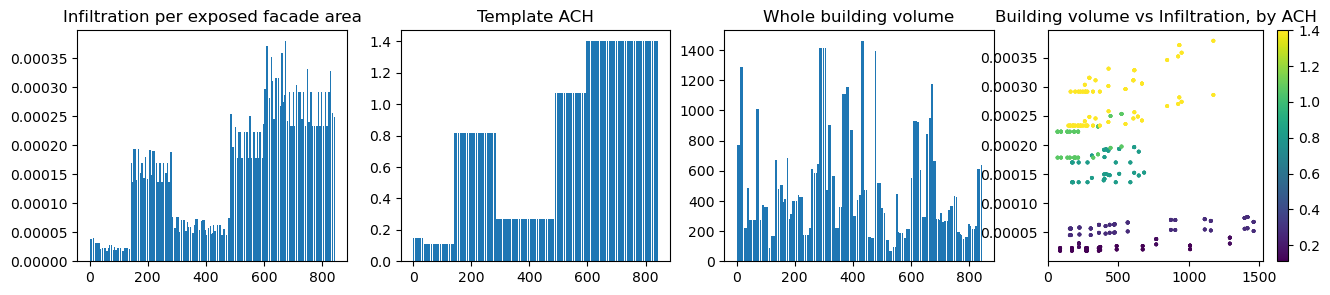

In [6]:
fig, ax = plt.subplots(1, 4, figsize=(16, 3))
x = np.arange(umi_test.shoeboxes_df.shape[0])
ax[0].bar(x, umi_test.shoeboxes_df["Infiltration"], label="Shoebox")
ax[0].set_title("Infiltration per exposed facade area")
ax[1].bar(x, umi_test.shoeboxes_df["ach"])
ax[1].set_title("Template ACH")
v = umi_test.shoeboxes_df["footprint_area"] * umi_test.shoeboxes_df["height"]
ax[2].bar(x, v)
ax[2].set_title("Whole building volume")
# form_factor = (umi_test.shoeboxes_df['building_perimeter'] * umi_test.shoeboxes_df['height'] + 2*umi_test.shoeboxes_df['footprint_area'])/(umi_test.shoeboxes_df['footprint_area']*umi_test.shoeboxes_df['floor_count'])
im = ax[3].scatter(
    v, umi_test.shoeboxes_df["Infiltration"], s=3, c=umi_test.shoeboxes_df["ach"]
)
fig.colorbar(im, ax=ax[3])
ax[3].set_title("Building volume vs Infiltration, by ACH")
fig.show()


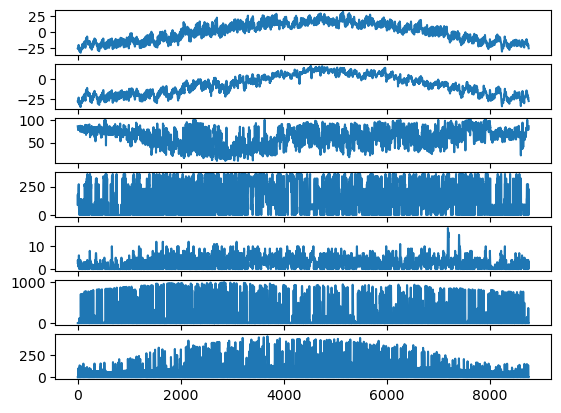

In [12]:
fig, ax = plt.subplots(umi_test.epw_array.shape[0], 1)
for i, row in enumerate(umi_test.epw_array):
    ax[i].plot(row)
plt.show()

In [18]:
umi_test.template_features_df


,PeopleDensity,LightingPowerDensity,EquipmentPowerDensity,Infiltration,VentilationPerArea,VentilationPerPerson,VentilationMode,HeatingSetpoint,CoolingSetpoint,humid_max,...,RoofRValue,RoofMass,SlabRValue,WindowShgc,WindowUValue,visible_transmittance,TemplateName,template_idx,cop_heating,cop_cooling
RefBldgFullServiceRestaurantPost1980_v1.4_7.2_2A_USA_TX_HOUSTON,0.538,24.4,475.0,0.816,0.0,0.0,MechVentMode.AllOn,20.5,24.5,81,...,0.062544,ThermalMassConstructions.SteelFrame,0.077803,1.0,5.823529,0.8,RefBldgFullServiceRestaurantPost1980_v1.4_7.2_...,0,0.692,2.37
RefBldgMediumOfficeNew2004_v1.4_7.2_2A_USA_TX_HOUSTON,0.0538,10.8,19.0,0.271,0.0,0.0,MechVentMode.AllOn,21.0,24.0,81,...,3.531932,ThermalMassConstructions.WoodFrame,0.283058,1.0,4.8,0.8,RefBldgMediumOfficeNew2004_v1.4_7.2_2A_USA_TX_...,1,0.692,2.37
RefBldgMidriseApartmentNew2004_v1.4_7.2_2A_USA_TX_HOUSTON,0.0281,4.29,12.6,0.149,0.0,0.0,MechVentMode.AllOn,20.6,25.5,81,...,3.531932,ThermalMassConstructions.WoodFrame,0.283058,1.0,5.0,0.8,RefBldgMidriseApartmentNew2004_v1.4_7.2_2A_USA...,2,0.692,2.37
RefBldgQuickServiceRestaurantPost1980_v1.4_7.2_2A_USA_TX_HOUSTON,0.387,16.0,864.0,1.07,0.0,0.0,MechVentMode.AllOn,20.0,25.0,81,...,0.062544,ThermalMassConstructions.SteelFrame,0.077803,1.0,5.823529,0.8,RefBldgQuickServiceRestaurantPost1980_v1.4_7.2...,3,0.692,2.37
RefBldgSecondarySchoolNew2004_v1.4_7.2_2A_USA_TX_HOUSTON,0.375,12.5,23.9,0.11,0.0,0.0,MechVentMode.AllOn,19.5,24.9,81,...,3.531932,ThermalMassConstructions.WoodFrame,0.283058,1.0,4.8,0.8,RefBldgSecondarySchoolNew2004_v1.4_7.2_2A_USA_...,4,0.692,2.37
RefBldgStand-aloneRetailPost1980_v1.4_7.2_2A_USA_TX_HOUSTON,0.141,32.3,5.24,1.4,0.0,0.0,MechVentMode.AllOn,18.9,26.7,81,...,5.55234,ThermalMassConstructions.WoodFrame,0.077803,1.0,5.823529,0.8,RefBldgStand-aloneRetailPost1980_v1.4_7.2_2A_U...,5,0.692,2.37


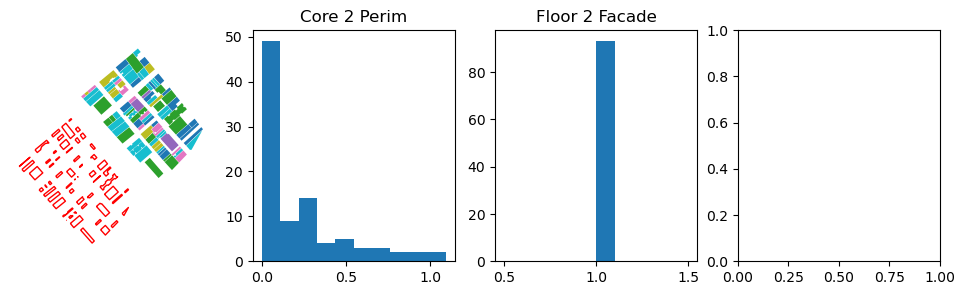

In [11]:
fig, ax = plt.subplots(1, 4, figsize=(12, 3))
ax[0] = umi_test.visualize_2d(ax=ax[0])
ax[1].hist(umi_test.gis_features_df["core_2_perim"])
ax[1].set_title("Core 2 Perim")
ax[2].hist(umi_test.gis_features_df["floor_2_facade"])
ax[2].set_title("Floor 2 Facade")
# ax[3].hist(umi_test.gis_features_df["roof_2_footprint"])
# ax[3].set_title("Roof/Ground 2 Footprint")
plt.show()

## 3. Open the UMI project(s) simulation results

We will be running the Florianopolis seed with a variety of different epw files.

The chosen ones:
- 0B: cityidx_0264_VEN_--CARACAS
- 2A: Florianopolis (baseline)
- 4C: cityidx_0725_ESP_--Avila
- 7: cityidx_0305_MNG_--ULAANBATAAR

In [10]:
month_map = {
    "january": 744,
    "february": 672,
    "march": 744,
    "april": 720,
    "may": 744,
    "june": 720,
    "july": 744,
    "august": 744,
    "september": 720,
    "october": 744,
    "november": 720,
    "december": 744,
}
sum(list(month_map.values()))

8760

In [11]:
areas = umi_test.gis_features_df[["building_id", "footprint_area", "floor_count"]]
areas["tfa"] = areas["footprint_area"] * areas["floor_count"]
areas = areas.sort_values("building_id")
areas.set_index("building_id", inplace=True)
areas.head()


,footprint_area,floor_count,tfa
building_id,,,
027e56c0-34b7-714a-9e97-08db9fc15045,46.028564,3.0,138.085692
095ce372-1a56-5744-a7be-6350e9250916,92.098678,1.0,92.098678
0a11abfe-8782-a241-a8c0-20bd08f70dbb,72.562633,1.0,72.562633
11ed3672-e6fb-354f-9f76-fc3e8fbcd50b,194.838924,1.0,194.838924
12f9435e-d5cc-bd40-9efa-c6ec52a9f804,82.491006,1.0,82.491006


In [12]:
cops = umi_test.gis_features_df[["building_id", "template_name"]]
cops = cops.merge(
    umi_test.template_features_df[
        [umi_test.template_name_col, "cop_heating", "cop_cooling"]
    ],
    left_on="template_name",
    right_on=umi_test.template_name_col,
)
cops = cops.sort_values("building_id")
cops.set_index("building_id", inplace=True)
cops.head()


,template_name,TemplateName,cop_heating,cop_cooling
building_id,,,,
027e56c0-34b7-714a-9e97-08db9fc15045,PROG_00_VINTAGE_03_MASS_1,PROG_00_VINTAGE_03_MASS_1,1.0,3.0
095ce372-1a56-5744-a7be-6350e9250916,PROG_01_VINTAGE_02_MASS_1,PROG_01_VINTAGE_02_MASS_1,1.0,3.0
0a11abfe-8782-a241-a8c0-20bd08f70dbb,PROG_02_VINTAGE_01_MASS_1,PROG_02_VINTAGE_01_MASS_1,1.0,3.0
11ed3672-e6fb-354f-9f76-fc3e8fbcd50b,PROG_02_VINTAGE_01_MASS_1,PROG_02_VINTAGE_01_MASS_1,1.0,3.0
12f9435e-d5cc-bd40-9efa-c6ec52a9f804,PROG_01_VINTAGE_02_MASS_1,PROG_01_VINTAGE_02_MASS_1,1.0,3.0


In [13]:
# Get monthly energy data
def get_monthly(h):
    h.set_index("Building Id", inplace=True)
    h = h[[str(x) for x in range(1, 8761)]]
    h.columns = h.columns.astype("int")
    c = 0
    for month, hours in month_map.items():
        h[month] = h.iloc[:, c : c + hours].sum(axis=1)
        c += hours
    return h[list(month_map.keys())]


seeds = ["caracas", "florianopolis", "avila", "ulaanbataar"]
simulated_umi_path = (
    Path(os.path.normpath(os.getcwd() + os.sep + os.pardir))
    / "umi_data"
    / "Florianopolis"
)
hourly_data_path = Path("data") / "SeedValidation"
heating = {}
cooling = {}
for city in seeds:
    d = {}
    h = pd.read_csv(hourly_data_path / f"seed_{city}_heating.csv")
    h = get_monthly(h)
    # Normalize by area
    h = h.divide(areas["tfa"], axis=0)
    # Get demand
    heating[city] = h.multiply(cops["cop_heating"], axis=0)
    c = pd.read_csv(hourly_data_path / f"seed_{city}_cooling.csv")
    c = get_monthly(c)
    c = c.divide(areas["tfa"], axis=0)
    cooling[city] = c.multiply(cops["cop_cooling"], axis=0)

monthly_targets = {}
for city in seeds:
    monthly_targets[city] = pd.concat([cooling[city], heating[city]], keys=["Cooling", "Heating"], axis=1)
monthly_targets = pd.concat(monthly_targets.values(), keys=monthly_targets.keys())


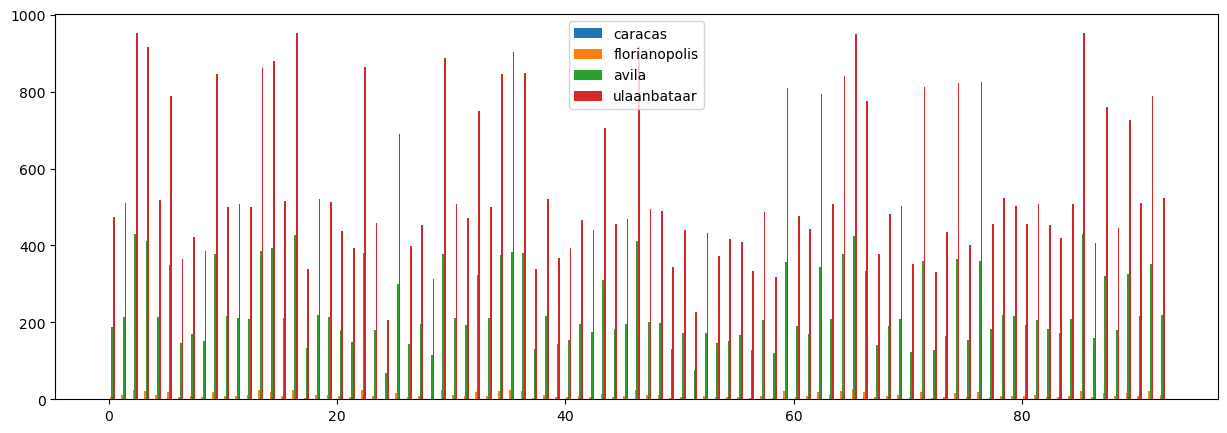

In [11]:
fig, ax = plt.subplots(figsize=(15, 5))
mlt = 0
width = 0.15
x = np.arange(93)
for city, vals in heating.items():
    offset = width * mlt
    rects = ax.bar(x + offset, vals.sum(axis=1), width, label=city)
    mlt += 1
plt.legend()

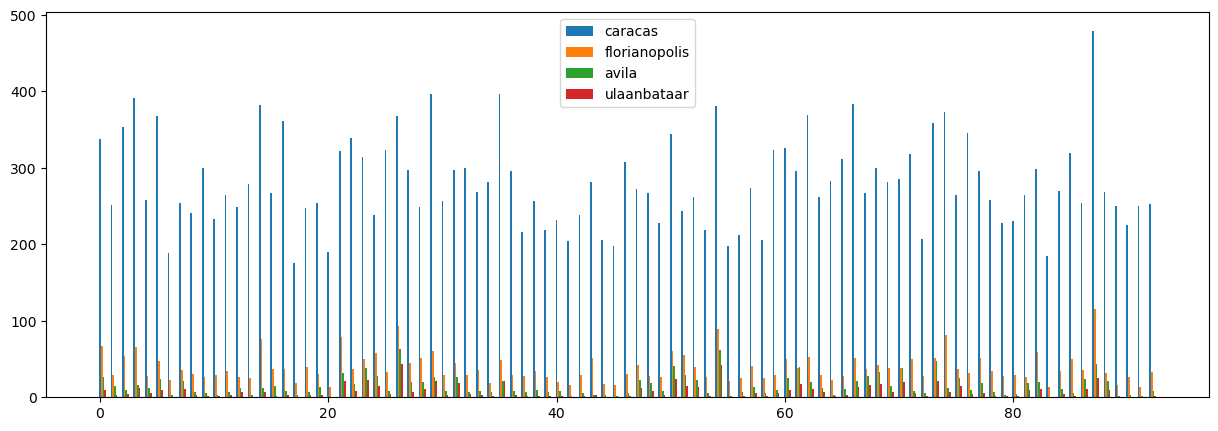

In [12]:
fig, ax = plt.subplots(figsize=(15, 5))
mlt = 0
for city, vals in cooling.items():
    offset = width * mlt
    rects = ax.bar(x + offset, vals.sum(axis=1), width, label=city)
    mlt += 1
plt.legend()

## 4. Run surrogate for built v2 shoeboxes & compare

In [16]:
umi_area_test = UBEM.open_umi(
    filename="D:/Users/zoelh/GitRepos/ml-for-building-energy-modeling/umi_data/Florianopolis/seed_florianopolis.umi",
    height_col="Height",
    id_col="id",
    wwr_col="WwrS",
    shoebox_gen_type="area",
)

INFO:UMI:reading input file...
DEBUG:UMI:TEMPORARY LOCATION C:\Users\zoelh\AppData\Local\Temp\tmpiln6woej
INFO:UMI:Successfully loaded EPW file Data for [Florianópolis]
DEBUG:UMI:['sdl-common/district_energy_scenarios.json', 'sdl-common/planningSettings.json', 'sdl-common/project.json', 'sdl-common/shoebox-weights.json', 'sdl-common/site-analysis-settings.json', 'sdl-common/ThermalPlantSettings.json', 'sdl-common/ubemio-archetype-id-cache.json', 'sdl-common/ud-results.xml', 'sdl-common/project-settings.json', 'sdl-common/project-header.json', 'Florianopolis_Baseline.3dm', 'BRA_SC-Florianopolis.838970_INMET.epw', 'CZ4A.json', 'umi.sqlite3']
INFO:UMI:Opening archetpal templates at CZ4A.json
DEBUG:UMI:Index(['id', 'FloorCount', 'GrossFloorArea', 'Height', 'Name', 'Occupancy',
       'TemplateName', 'UseType', 'WwrE', 'WwrN', 'WwrS', 'WwrW', 'geometry'],
      dtype='object')
INFO:UMI:Read 9.8KB from D:/Users/zoelh/GitRepos/ml-for-building-energy-modeling/umi_data/Florianopolis/seed_floria

In [2]:
from ml.predict import predict_ubem
from lightning.pytorch import Trainer
from ml.data import BuildingDataModule
from ml.surrogate import Surrogate

climate_array_path = "data/epws/global_climate_array.npy"


Couldn't import dot_parser, loading of dot files will not be possible.


In [18]:
bucket = "ml-for-bem"
remote_experiment = "full_climate_zone/v5"
local_data_dir = "data/lightning"

registry = "ml-for-building-energy-modeling/model-registry"
model = "Global UBEM Shoebox Surrogate with Combined TS Embedder"
tag = "v1"
resource = "model-with-transform-configs.ckpt"

surrogate = Surrogate.load_from_registry(registry, model, tag, resource)
surrogate.model.eval()

# dm = BuildingDataModule(
#         bucket=bucket,
#         remote_experiment=remote_experiment,
#         data_dir=local_data_dir,
#         climate_array_path=climate_array_path,
#         batch_size=128,
#         val_batch_mult=8,
#     )

# dm.setup(stage=None)

trainer = Trainer(
    accelerator="auto",
    devices="auto",
    strategy="auto",
    enable_progress_bar=True,
)

c:\Users\zoelh\AppData\Local\anaconda3\envs\ml-for-bem\lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'target_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['target_transform'])`.
c:\Users\zoelh\AppData\Local\anaconda3\envs\ml-for-bem\lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'weather_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['weather_transform'])`.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, u

In [4]:
import torch
# torch.cuda.empty_cache()

In [19]:
features, schedules, climate = umi_test.prepare_for_surrogate()
features["WindowShgc"] = 0.9
features[features["WindowUValue"] > 7]["WindowUValue"] = 7.0

In [20]:
features_area, schedules_area, climate_area = umi_test.prepare_for_surrogate()
features_area["WindowShgc"] = 0.9
features_area[features_area["WindowUValue"] > 7]["WindowUValue"] = 7.0

In [21]:
# Change the weather file if needed
weather_files = [
    "cityidx_0264_VEN_--CARACAS.804150_IWEC Data.epw",
    "BRA_SC-Florianopolis.838970_INMET.epw",
    "cityidx_0725_ESP_--Avila.082100_SWEC.epw",
    "cityidx_0305_MNG_--ULAANBATAAR.442920_IWEC Data.epw",
]
seeds = ["caracas", "florianopolis", "avila", "ulaanbataar"]

shoebox_predictions = {}
monthly_predictions = {}
annual_predictions = {}
shoebox_area_predictions = {}
monthly_area_predictions = {}
annual_area_predictions = {}

for i, city in enumerate(seeds):
    epw_fp = (
        Path("data")
        / "epws"
        / "global_epws_indexed"
        / weather_files[i]
    )
    epw = EPW(epw_fp)
    climate = umi_test.prepare_epw_features(epw)

    torch.set_float32_matmul_precision("medium")
    shoebox_predictions[city], monthly_predictions[city], annual_predictions[city] = predict_ubem(
        trainer=trainer,
        surrogate=surrogate,
        features=features,
        schedules=schedules,
        climate=climate,
        batch_size=12,
        apply_cops=False
    )
    shoebox_area_predictions[city], monthly_area_predictions[city], annual_area_predictions[city] = predict_ubem(
        trainer=trainer,
        surrogate=surrogate,
        features=features_area,
        schedules=schedules_area,
        climate=climate,
        batch_size=12,
        apply_cops=False
    )

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\zoelh\AppData\Local\anaconda3\envs\ml-for-bem\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 53/53 [00:05<00:00, 10.56it/s]


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\zoelh\AppData\Local\anaconda3\envs\ml-for-bem\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 53/53 [00:04<00:00, 10.78it/s]


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\zoelh\AppData\Local\anaconda3\envs\ml-for-bem\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 53/53 [00:03<00:00, 14.52it/s]


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\zoelh\AppData\Local\anaconda3\envs\ml-for-bem\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 53/53 [00:03<00:00, 14.60it/s]


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\zoelh\AppData\Local\anaconda3\envs\ml-for-bem\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 53/53 [00:03<00:00, 14.49it/s]


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\zoelh\AppData\Local\anaconda3\envs\ml-for-bem\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 53/53 [00:03<00:00, 14.55it/s]


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\zoelh\AppData\Local\anaconda3\envs\ml-for-bem\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 53/53 [00:03<00:00, 14.50it/s]


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\zoelh\AppData\Local\anaconda3\envs\ml-for-bem\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 53/53 [00:03<00:00, 14.74it/s]


## 5. Compare results

In [25]:
# Turn results into multi-indexes
annual_predictions = pd.concat(annual_predictions.values(), keys=annual_predictions.keys())
monthly_predictions = pd.concat(monthly_predictions.values(), keys=monthly_predictions.keys())

In [ ]:
annual_area_predictions = pd.concat(annual_area_predictions.values(), keys=annual_area_predictions.keys())
monthly_area_predictions = pd.concat(monthly_area_predictions.values(), keys=monthly_area_predictions.keys())

array([[<Axes: title={'center': "('Cooling', 'caracas')"}>,
        <Axes: title={'center': "('Cooling', 'florianopolis')"}>,
        <Axes: title={'center': "('Cooling', 'avila')"}>],
       [<Axes: title={'center': "('Cooling', 'ulaanbataar')"}>,
        <Axes: title={'center': "('Heating', 'caracas')"}>,
        <Axes: title={'center': "('Heating', 'florianopolis')"}>],
       [<Axes: title={'center': "('Heating', 'avila')"}>,
        <Axes: title={'center': "('Heating', 'ulaanbataar')"}>, <Axes: >]],
      dtype=object)

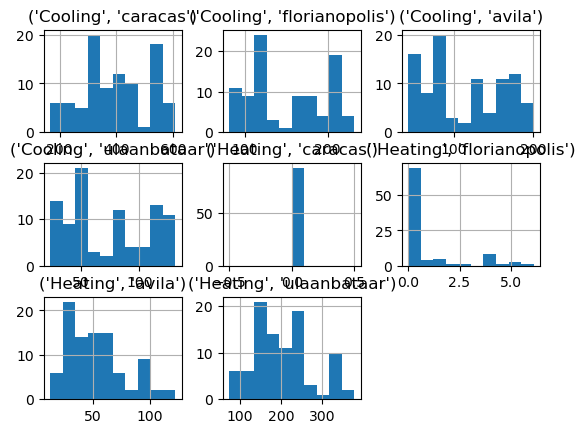

In [27]:
annual_predictions.unstack(level=0).hist()

array([[<Axes: title={'center': "('Cooling', 'caracas')"}>,
        <Axes: title={'center': "('Cooling', 'florianopolis')"}>,
        <Axes: title={'center': "('Cooling', 'avila')"}>],
       [<Axes: title={'center': "('Cooling', 'ulaanbataar')"}>,
        <Axes: title={'center': "('Heating', 'caracas')"}>,
        <Axes: title={'center': "('Heating', 'florianopolis')"}>],
       [<Axes: title={'center': "('Heating', 'avila')"}>,
        <Axes: title={'center': "('Heating', 'ulaanbataar')"}>, <Axes: >]],
      dtype=object)

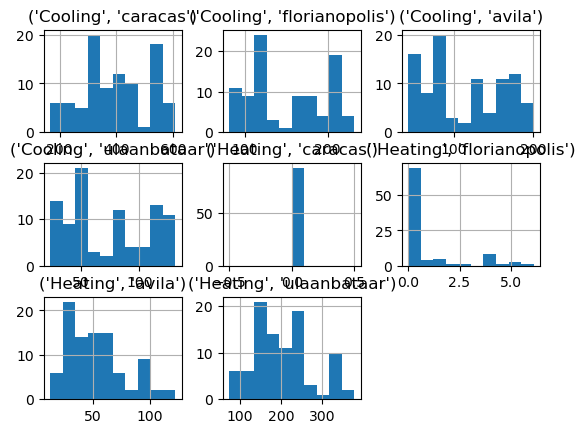

In [28]:
annual_area_predictions.unstack(level=0).hist()

C:\Users\zoelh\AppData\Local\Temp\ipykernel_679060\755112175.py:1: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  monthly_targets.sum(axis=1, level=0).unstack(level=0).hist()


array([[<Axes: title={'center': "('Cooling', 'caracas')"}>,
        <Axes: title={'center': "('Cooling', 'florianopolis')"}>,
        <Axes: title={'center': "('Cooling', 'avila')"}>],
       [<Axes: title={'center': "('Cooling', 'ulaanbataar')"}>,
        <Axes: title={'center': "('Heating', 'caracas')"}>,
        <Axes: title={'center': "('Heating', 'florianopolis')"}>],
       [<Axes: title={'center': "('Heating', 'avila')"}>,
        <Axes: title={'center': "('Heating', 'ulaanbataar')"}>, <Axes: >]],
      dtype=object)

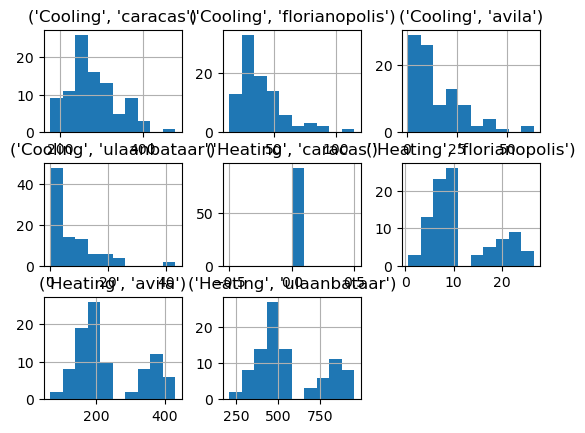

In [29]:
monthly_targets.sum(axis=1, level=0).unstack(level=0).hist()

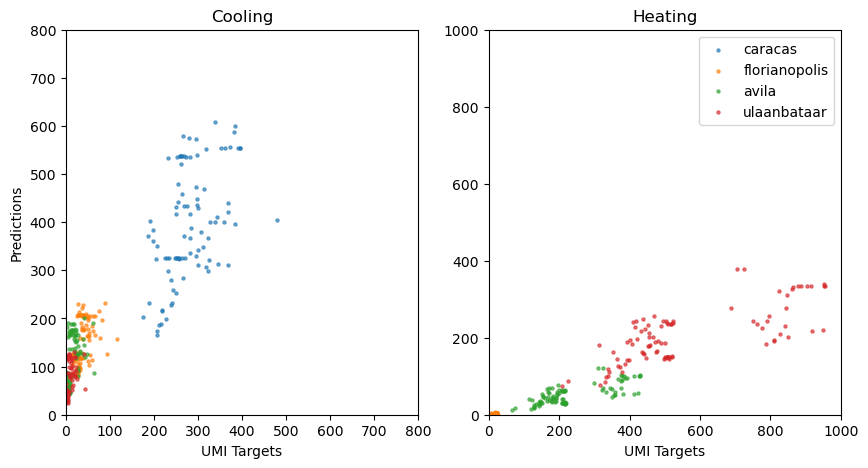

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
for i, city in enumerate(seeds):
    ax[0].scatter(
        monthly_targets["Cooling"].loc[city].sum(axis=1).values,
        annual_predictions["Cooling"].loc[city].values,
        label=city,
        s=5,
        alpha=0.6,
    )
    ax[1].scatter(
        monthly_targets["Heating"].loc[city].sum(axis=1).values, 
        annual_predictions["Heating"].loc[city].values,
        label=city,
        s=5,
        alpha=0.6,
    )
ax[0].set_title("Cooling")
ax[0].set_ylabel("Predictions")
ax[0].set_xlabel("UMI Targets")
ax[0].set_ylim(0, 800)
ax[0].set_xlim(0, 800)
ax[1].set_title("Heating")
ax[1].set_xlabel("UMI Targets")
ax[1].set_ylim(0, 1000)
ax[1].set_xlim(0, 1000)
ax[1].legend()

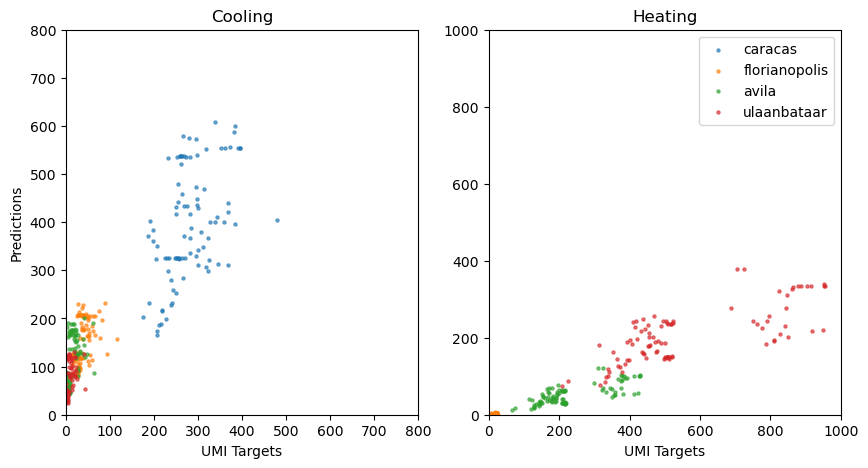

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
for i, city in enumerate(seeds):
    ax[0].scatter(
        monthly_targets["Cooling"].loc[city].sum(axis=1).values,
        annual_area_predictions["Cooling"].loc[city].values,
        label=city,
        s=5,
        alpha=0.6,
    )
    ax[1].scatter(
        monthly_targets["Heating"].loc[city].sum(axis=1).values, 
        annual_area_predictions["Heating"].loc[city].values,
        label=city,
        s=5,
        alpha=0.6,
    )
ax[0].set_title("Cooling")
ax[0].set_ylabel("Predictions")
ax[0].set_xlabel("UMI Targets")
ax[0].set_ylim(0, 800)
ax[0].set_xlim(0, 800)
ax[1].set_title("Heating")
ax[1].set_xlabel("UMI Targets")
ax[1].set_ylim(0, 1000)
ax[1].set_xlim(0, 1000)
ax[1].legend()

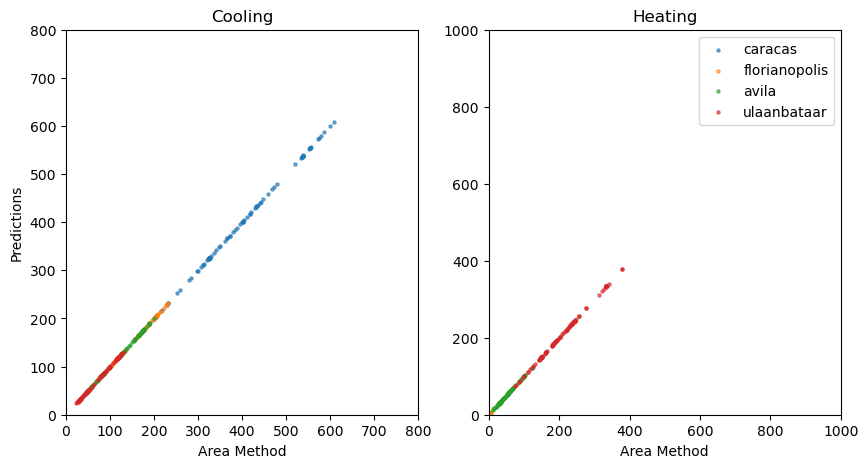

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
for i, city in enumerate(seeds):
    ax[0].scatter(
        annual_area_predictions["Cooling"].loc[city].values,
        annual_predictions["Cooling"].loc[city].values,
        label=city,
        s=5,
        alpha=0.6,
    )
    ax[1].scatter(
        annual_area_predictions["Heating"].loc[city].values, 
        annual_predictions["Heating"].loc[city].values,
        label=city,
        s=5,
        alpha=0.6,
    )
ax[0].set_title("Cooling")
ax[0].set_ylabel("Predictions")
ax[0].set_xlabel("Area Method")
ax[0].set_ylim(0, 800)
ax[0].set_xlim(0, 800)
ax[1].set_title("Heating")
ax[1].set_xlabel("Area Method")
ax[1].set_ylim(0, 1000)
ax[1].set_xlim(0, 1000)
ax[1].legend()

C:\Users\zoelh\AppData\Local\Temp\ipykernel_667408\1951077231.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


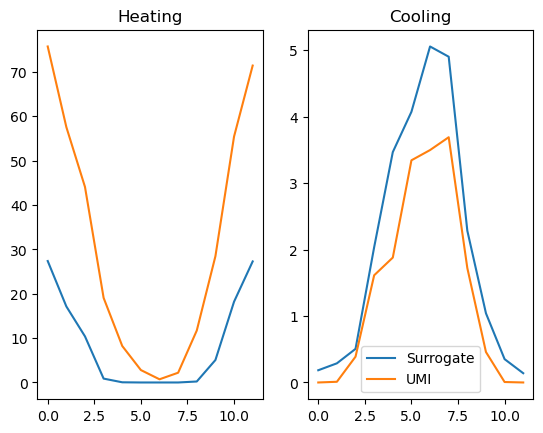

In [20]:
fig, ax = plt.subplots(1, 2)
for i in range(1):
    sample = heating["ulaanbataar"].sample()
    bldg_id = sample.index[0]
    ax[0].plot(monthly_predictions["Heating"].loc[bldg_id].values, label="Surrogate")
    ax[0].plot(sample.T.values, label="UMI")
    ax[0].set_title("Heating")
    ax[1].plot(monthly_predictions["Cooling"].loc[bldg_id].values, label="Surrogate")
    ax[1].plot(cooling["ulaanbataar"].loc[bldg_id].values, label="UMI")
    ax[1].legend()
    ax[1].set_title("Cooling")
fig.show()

#### Error calculations

In [45]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def error_report(ground_truth, surrogate_predictions):
    error = pd.Series(dtype="float64")
    error["mae"] = mean_absolute_error(ground_truth, surrogate_predictions)
    error["mse"] = mean_squared_error(ground_truth, surrogate_predictions)
    error["rmse"] = np.sqrt(error["mse"])
    error["mape"] = mean_absolute_percentage_error(ground_truth, surrogate_predictions)
    error["r2"] = r2_score(ground_truth, surrogate_predictions)
    return error

In [47]:
errors = pd.DataFrame()
errors["heating"] = error_report(heating["ulaanbataar"].to_numpy(), monthly_predictions["Heating"].to_numpy())
errors["cooling"] = error_report(cooling["ulaanbataar"].to_numpy(), monthly_predictions["Cooling"].to_numpy())
errors

C:\Users\zoelh\AppData\Local\Temp\ipykernel_667408\3573048853.py:4: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
C:\Users\zoelh\AppData\Local\Temp\ipykernel_667408\3573048853.py:4: RuntimeWarning: invalid value encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


,heating,cooling
mae,30.027307,6.499729
mse,1519.511012,86.651064
rmse,38.980906,9.308655
mape,79.003774,NaN
r2,-3.168773,-785065.312943


## 3.a If a simulated UMI, fetch shoeboxes & results

In [ ]:
from pyumi import UmiProject
from pyumi.shoeboxer import ShoeBox
from pyumi.umi_project import ShoeBoxCollection


def fetch_shoeboxes(simulated_shoeboxdf):
    shoeboxes = ShoeBoxCollection()
    df = simulated_shoeboxdf.reset_index().groupby("ShoeboxPath").first().reset_index()
    for _, row in df.iterrows():
        idf_path = row["ShoeboxPath"]
        shoeboxes[idf_path] = ShoeBox(idf_path)
    return shoeboxes


def set_energy_path(simulated_shoeboxdf, new_path):
    old_paths = simulated_shoeboxdf["ShoeboxPath"]
    new_paths = []

    new_path = os.path.normpath(new_path)
    to_match = new_path.split(os.sep)[-1]
    idx = old_paths[0].split("\\").index(to_match)
    for p in old_paths:
        p = p.split("\\")
        new_p = new_path
        for i in range(idx + 1, len(p)):
            new_p = os.path.join(new_p, p[i])
        new_paths.append(new_p)

    simulated_shoeboxdf["ShoeboxPath"] = new_paths
    return simulated_shoeboxdf


simulated_umi_path = "D:/Users/zoelh/GitRepos/ml-for-building-energy-modeling/umi_data/Florianopolis/Florianopolis_Baseline_simulated.umi"
energy_path = "D:/Users/zoelh/GitRepos/ml-for-building-energy-modeling/umi_data/Florianopolis/hourly/eplus"
simulated_umi = UmiProject.open(simulated_umi_path)

In [13]:
df = pd.DataFrame.from_dict(simulated_umi.sdl_common["shoebox-weights"])
simulated_shoeboxdf = df.merge(
    simulated_umi.gdf_world, how="left", left_on="ParentBuildingId", right_on="id"
)
simulated_shoeboxdf = set_energy_path(simulated_shoeboxdf, energy_path)
simulated_shoeboxdf.head()

,ParentBuildingId,PerimeterAreaWeight,CoreAreaWeight,PerimeterArea,CoreArea,Orientation,ClusterId,Roof2FloorRatio,Ground2FloorRatio,Floor2Fac,...,Height,Name,Occupancy,TemplateName,UseType,WwrE,WwrN,WwrS,WwrW,geometry
0,b8848bab-34b8-6b44-bb4c-43deca1051a6,5.817445,0.0,240.45439,0.0,West,Group0,0.5,0.5,0.450772,...,8.4,44,134,RefBldgSecondarySchoolNew2004_v1.4_7.2_2A_USA_...,Uncategorized,0.4,0.4,0.4,0.4,"MULTIPOLYGON (((741947.18906 -3055188.98301, 7..."
1,b8848bab-34b8-6b44-bb4c-43deca1051a6,3.878297,0.0,240.45439,0.0,West,Group0,0.5,0.5,0.450772,...,8.4,44,134,RefBldgSecondarySchoolNew2004_v1.4_7.2_2A_USA_...,Uncategorized,0.4,0.4,0.4,0.4,"MULTIPOLYGON (((741947.18906 -3055188.98301, 7..."
2,b8848bab-34b8-6b44-bb4c-43deca1051a6,3.878297,0.0,240.45439,0.0,South,Group0,0.5,0.5,0.450772,...,8.4,44,134,RefBldgSecondarySchoolNew2004_v1.4_7.2_2A_USA_...,Uncategorized,0.4,0.4,0.4,0.4,"MULTIPOLYGON (((741947.18906 -3055188.98301, 7..."
3,b8848bab-34b8-6b44-bb4c-43deca1051a6,5.817445,0.0,240.45439,0.0,South,Group0,0.5,0.5,0.450772,...,8.4,44,134,RefBldgSecondarySchoolNew2004_v1.4_7.2_2A_USA_...,Uncategorized,0.4,0.4,0.4,0.4,"MULTIPOLYGON (((741947.18906 -3055188.98301, 7..."
4,b8848bab-34b8-6b44-bb4c-43deca1051a6,1.939148,0.0,240.45439,0.0,South,Group0,0.5,0.5,0.450772,...,8.4,44,134,RefBldgSecondarySchoolNew2004_v1.4_7.2_2A_USA_...,Uncategorized,0.4,0.4,0.4,0.4,"MULTIPOLYGON (((741947.18906 -3055188.98301, 7..."


In [11]:
from archetypal import settings
import subprocess

settings.energyplus_location = Path("D:\EnergyPlusV22-2-0")
settings.ep_version = "22.2.0"


def convert(fullpath):
    # Define the command and its arguments
    output_directory, path = os.path.split(fullpath)
    cmd = (
        settings.energyplus_location / f"energyplus{'.exe' if os.name == 'nt' else ''}"
    )
    args = ["--convert-only", "--output-directory", output_directory, fullpath]

    # TODO change location of idf

    # Run the command
    with subprocess.Popen(
        [cmd] + args, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True
    ) as proc:
        for line in proc.stdout:
            print(line.strip())
        exit_code = proc.wait()

    # Check if the command was successful
    if exit_code == 0:
        pass
    else:
        print(f"Command failed with exit code {exit_code}.")
        raise RuntimeError(f"Failed to convert EpJSON to IDF.")


# def setup_update(shoeboxes_dict, updated_directory):
#     # Make list of files to convert
#     files_to_convert = list(shoeboxes_dict.keys())
#     with open(Path(updated_directory, "to_convert.lst"), "w") as f:
#         f.writelines(line + '\n' for line in files_to_convert)
# setup_update(simulated_shoeboxes, "D:/Users/zoelh/GitRepos/ml-for-building-energy-modeling/umi_data/Florianopolis/eplus/converted")


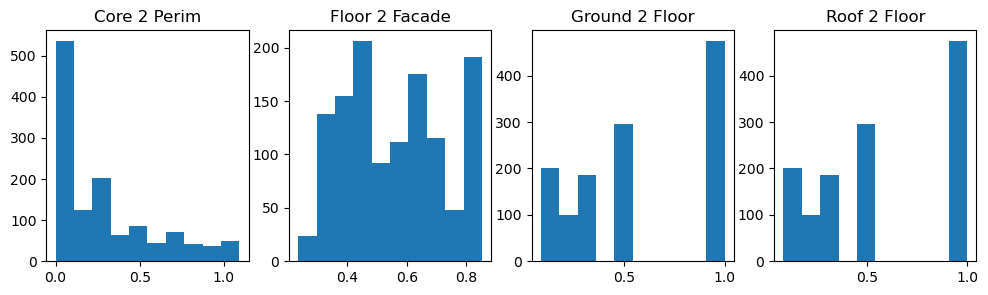

In [31]:
fig, ax = plt.subplots(1, 4, figsize=(12, 3))
ax[0].hist(simulated_shoeboxdf["Core2Perimeter"])
ax[0].set_title("Core 2 Perim")
ax[1].hist(simulated_shoeboxdf["Floor2Fac"])
ax[1].set_title("Floor 2 Facade")
ax[2].hist(simulated_shoeboxdf["Ground2FloorRatio"])
ax[2].set_title("Ground 2 Floor")
ax[3].hist(simulated_shoeboxdf["Roof2FloorRatio"])
ax[3].set_title("Roof 2 Floor")
plt.show()

### Load all the eplus outputs

In [58]:
ENERGY_DIR = "ml-for-bem/umi/energy"
ENERGY_CSV_OUTPUTS = [
    "Date/Time",
    # "PERIM:Zone People Total Heating Energy [J](Hourly)",
    # "CORE:Zone People Total Heating Energy [J](Hourly)",
    # "PERIM:Zone Lights Electric Energy [J](Hourly)",
    # "CORE:Zone Lights Electric Energy [J](Hourly)",
    # "PERIM:Zone Electric Equipment Electric Energy [J](Hourly)",
    # "CORE:Zone Electric Equipment Electric Energy [J](Hourly)",
    # "PERIM:Zone Windows Total Transmitted Solar Radiation Energy [J](Hourly)",
    # "CORE:Zone Windows Total Transmitted Solar Radiation Energy [J](Hourly)",
    # "PERIM:Zone Mean Radiant Temperature [C](Hourly)",
    # "CORE:Zone Mean Radiant Temperature [C](Hourly)",
    # "PERIM:Zone Mean Air Temperature [C](Hourly)",
    # "PERIM:Zone Operative Temperature [C](Hourly)",
    # "CORE:Zone Mean Air Temperature [C](Hourly)",
    # "CORE:Zone Operative Temperature [C](Hourly)",
    # "PERIM:Zone Infiltration Total Heat Loss Energy [J](Hourly)",
    # "PERIM:Zone Infiltration Total Heat Gain Energy [J](Hourly)",
    # "PERIM:Zone Infiltration Air Change Rate [ach](Hourly)",
    # "CORE:Zone Infiltration Total Heat Loss Energy [J](Hourly)",
    # "CORE:Zone Infiltration Total Heat Gain Energy [J](Hourly)",
    # "CORE:Zone Infiltration Air Change Rate [ach](Hourly)",
    # "PERIM:Zone Air Temperature [C](Hourly)",
    # "PERIM:Zone Air Relative Humidity [%](Hourly)",
    # "CORE:Zone Air Temperature [C](Hourly)",
    # "CORE:Zone Air Relative Humidity [%](Hourly)",
    "PERIM IDEAL LOADS AIR:Zone Ideal Loads Supply Air Total Heating Energy [J](Hourly)",
    "PERIM IDEAL LOADS AIR:Zone Ideal Loads Supply Air Total Cooling Energy [J](Hourly)",
    # "PERIM IDEAL LOADS AIR:Zone Ideal Loads Zone Total Heating Energy [J](Hourly)",
    "CORE IDEAL LOADS AIR:Zone Ideal Loads Supply Air Total Heating Energy [J](Hourly)",
    "CORE IDEAL LOADS AIR:Zone Ideal Loads Supply Air Total Cooling Energy [J](Hourly)",
    # "CORE IDEAL LOADS AIR:Zone Ideal Loads Zone Total Heating Energy [J](Hourly)",
    # "DHW PERIM:Water Use Equipment Heating Energy [J](Hourly)",
    # "DHW CORE:Water Use Equipment Heating Energy [J](Hourly)",
]


def fetch_raw_shoebox_results(idf_path):
    csv_path = idf_path.replace("idf", "csv")
    try:
        pandas_df = pd.read_csv(csv_path)
        pandas_df.columns = pandas_df.columns.str.strip()
        cols = pandas_df.columns.tolist()
    except Exception as e:
        print(f"Error opening energy csv: {csv_path}")
        raise e

    # TODO: if there is no water use equipment this is not added to the idf and is not in the csv output
    # Temporary fix to add zeros if there is a missing entry
    if len(cols) != len(ENERGY_CSV_OUTPUTS):
        # print(f"Missing some outputs for {csv_path}")
        for col in ENERGY_CSV_OUTPUTS:
            if col not in cols:
                print(
                    f"Could not find results for {col} in {csv_path}. Assuming no energy use (zeros)."
                )
                pandas_df[col] = 0
        # reorganize columns in correct order
        pandas_df = pandas_df[ENERGY_CSV_OUTPUTS]
    new_cols = []
    for c in pandas_df.columns:
        if "[J]" in c:
            pandas_df[c] = pandas_df[c] * JOULES_TO_KWH
        c = c.split(" [")[0]
        new_cols.append(c)
    pandas_df.columns = new_cols
    return pandas_df


# Check with one shoebox
edf = fetch_raw_shoebox_results(simulated_shoeboxdf["ShoeboxPath"][0])
edf.describe()

,PERIM IDEAL LOADS AIR:Zone Ideal Loads Supply Air Total Heating Energy,PERIM IDEAL LOADS AIR:Zone Ideal Loads Supply Air Total Cooling Energy,CORE IDEAL LOADS AIR:Zone Ideal Loads Supply Air Total Heating Energy,CORE IDEAL LOADS AIR:Zone Ideal Loads Supply Air Total Cooling Energy
count,8760.0,8760.000000,8760.0,8760.000000
mean,0.0,0.089042,0.0,0.060820
std,0.0,0.121163,0.0,0.079270
min,0.0,0.000000,0.0,0.000000
25%,0.0,0.000000,0.0,0.000000
50%,0.0,0.000000,0.0,0.000000
75%,0.0,0.166338,0.0,0.121131
max,0.0,0.492293,0.0,0.216114


## Compare an idf to surrogate

## OLD Comparing epjson shoeboxer with umi outputs (to review)

In [55]:
parent_ids = simulated_shoeboxdf[
    simulated_shoeboxdf["ShoeboxPath"] == df["ShoeboxPath"][0]
]["ParentBuildingId"].unique()


In [68]:
n_sbs = simulated_shoeboxdf[
    simulated_shoeboxdf["ParentBuildingId"].isin(parent_ids)
].shape[0]
n_idfs = (
    simulated_shoeboxdf[simulated_shoeboxdf["ParentBuildingId"].isin(parent_ids)][
        "ShoeboxPath"
    ]
    .unique()
    .shape[0]
)


In [69]:
f"for {len(parent_ids)} buildings", f"{n_sbs} Shoeboxes", f"and {n_idfs} .idf files"

('for 27 buildings', '471 Shoeboxes', 'and 56 .idf files')

In [116]:
g0df = (
    simulated_shoeboxdf[simulated_shoeboxdf["ClusterId"] == "Group0"][
        [
            "ParentBuildingId",
            "Orientation",
            "ShoeboxPath",
            "PerimeterAreaWeight",
            "CoreAreaWeight",
            "PerimeterArea",
            "CoreArea",
            "Roof2FloorRatio",
            "Ground2FloorRatio",
            "Floor2Fac",
            "Core2Perimeter",
        ]
    ].sort_values(["ParentBuildingId", "Orientation"])
    # .iloc[:20]
)
g0df["ShoeboxPath"] = g0df.ShoeboxPath.apply(lambda x: "-".join(x.split("\\")[-3:]))
g0df.groupby(["Orientation", "ShoeboxPath"]).count()


ParentBuildingId  PerimeterAreaWeight  \
Orientation ShoeboxPath                                                       
East        SAMPLE10-40-SAMPLE10.idf                12                   12   
            SAMPLE11-40-SAMPLE11.idf                14                   14   
            SAMPLE12-40-SAMPLE12.idf                11                   11   
            SAMPLE13-40-SAMPLE13.idf                17                   17   
            SAMPLE14-40-SAMPLE14.idf                24                   24   
...                                                ...                  ...   
West        SAMPLE60-40-SAMPLE60.idf                 6                    6   
            SAMPLE61-40-SAMPLE61.idf                 2                    2   
            SAMPLE62-40-SAMPLE62.idf                11                   11   
            SAMPLE63-40-SAMPLE63.idf                 3                    3   
            SAMPLE9-40-SAMPLE9.idf                   2                    2   

                                      CoreAreaWeight  PerimeterArea  CoreArea  \
Orientation ShoeboxPath                                                         
East        SAMPLE10-40-SAMPLE10.idf              12             12        12   
            SAMPLE11-40-SAMPLE11.idf              14             14        14   
            SAMPLE12-40-SAMPLE12.idf              11             11        11   
            SAMPLE13-40-SAMPLE13.idf              17             17        17   
            SAMPLE14-40-SAMPLE14.idf              24             24        24   
...                                              ...            ...       ...   
West        SAMPLE60-40-SAMPLE60.idf               6              6         6   
            SAMPLE61-40-SAMPLE61.idf               2              2         2   
            SAMPLE62-40-SAMPLE62.idf              11             11        11   
            SAMPLE63-40-SAMPLE63.idf               3              3         3   
            SAMPLE9-40-SAMPLE9.idf                 2              2         2   

                                      Roof2FloorRatio  Ground2FloorRatio  \
Orientation ShoeboxPath                                                    
East        SAMPLE10-40-SAMPLE10.idf               12                 12   
            SAMPLE11-40-SAMPLE11.idf               14                 14   
            SAMPLE12-40-SAMPLE12.idf               11                 11   
            SAMPLE13-40-SAMPLE13.idf               17                 17   
            SAMPLE14-40-SAMPLE14.idf               24                 24   
...                                               ...                ...   
West        SAMPLE60-40-SAMPLE60.idf                6                  6   
            SAMPLE61-40-SAMPLE61.idf                2                  2   
            SAMPLE62-40-SAMPLE62.idf               11                 11   
            SAMPLE63-40-SAMPLE63.idf                3                  3   
            SAMPLE9-40-SAMPLE9.idf                  2                  2   

                                      Floor2Fac  Core2Perimeter  
Orientation ShoeboxPath                                          
East        SAMPLE10-40-SAMPLE10.idf         12              12  
            SAMPLE11-40-SAMPLE11.idf         14              14  
            SAMPLE12-40-SAMPLE12.idf         11              11  
            SAMPLE13-40-SAMPLE13.idf         17              17  
            SAMPLE14-40-SAMPLE14.idf         24              24  
...                                         ...             ...  
West        SAMPLE60-40-SAMPLE60.idf          6               6  
            SAMPLE61-40-SAMPLE61.idf          2               2  
            SAMPLE62-40-SAMPLE62.idf         11              11  
            SAMPLE63-40-SAMPLE63.idf          3               3  
            SAMPLE9-40-SAMPLE9.idf            2               2  

[99 rows x 9 columns]